# Custom Model Training

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, metrics
from tensorflow.keras.models import Sequential
import pathlib
import pandas as pd
from PIL import Image 
from PIL.ImageDraw import Draw

2024-02-19 20:08:11.968531: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 20:08:11.968586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 20:08:11.995040: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 20:08:12.061892: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 20:08:14.050604: W tensorflow/compiler/tf2

## Importing Data

Make sure you have downloaded the dataset in PASCAL_VOC format and saved them under a new folder called 'images'.
Run pascal_csv.py with SKIP_NEGATIVE = True. 

In [30]:

classes = ["none", "ball", "cone"]
INPUT_SIZE = (324, 244 , 1) #whc
NUM_CLASSES = 3   # None, Ball, Cone
FIRST_LAYER_STRIDE = 2

TRAINING_CSV_FILE = 'data/train_data.csv'
TRAINING_IMAGE_DIR = 'images/train'
training_image_records = pd.read_csv(TRAINING_CSV_FILE)
train_image_path = os.path.join(os.getcwd(), TRAINING_IMAGE_DIR)

train_images = []
train_targets = []
train_labels = []

for index, row in training_image_records.iterrows():
    
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
        
    train_image_fullpath = os.path.join(train_image_path, filename)
    train_img = keras.preprocessing.image.load_img(train_image_fullpath, target_size=(height, width), color_mode='grayscale')  # Convert to grayscale
    train_img_arr = keras.preprocessing.image.img_to_array(train_img)
    train_img_arr = np.transpose(train_img_arr, (1, 0, 2))

    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    train_images.append(train_img_arr)
    train_targets.append((xmin, ymin, xmax, ymax))
    train_labels.append(classes.index(class_name))

VALID_CSV_FILE = 'data/valid_data.csv'
VALID_IMAGE_DIR = 'images/valid'
valid_image_records = pd.read_csv(VALID_CSV_FILE)
valid_image_path = os.path.join(os.getcwd(), VALID_IMAGE_DIR)

valid_images = []
valid_targets = []
valid_labels = []

for index, row in valid_image_records.iterrows():
    
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
    
    valid_image_fullpath = os.path.join(valid_image_path, filename)
    valid_img = keras.preprocessing.image.load_img(valid_image_fullpath, target_size=(height, width), color_mode='grayscale')  # Convert to grayscale
    valid_img_arr = keras.preprocessing.image.img_to_array(valid_img)
    valid_img_arr = np.transpose(valid_img_arr, (1, 0, 2))
    
    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    valid_images.append(valid_img_arr)
    valid_targets.append((xmin, ymin, xmax, ymax))
    valid_labels.append(classes.index(class_name))


TEST_CSV_FILE = 'data/test_data.csv'
TEST_IMAGE_DIR = 'images/test'  # Adjust this directory according to your test image directory
test_image_records = pd.read_csv(TEST_CSV_FILE)
test_image_path = os.path.join(os.getcwd(), TEST_IMAGE_DIR)

test_images = []
test_targets = []
test_labels = []

for index, row in test_image_records.iterrows():
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    test_image_fullpath = os.path.join(test_image_path, filename)
    test_img = keras.preprocessing.image.load_img(test_image_fullpath, target_size=(height, width), color_mode='grayscale')  # Convert to grayscale
    test_img_arr = keras.preprocessing.image.img_to_array(test_img)
    test_img_arr = np.transpose(test_img_arr, (1, 0, 2))
    # print(test_img_arr.shape)

    xmin = round(xmin / width, 2)
    ymin = round(ymin / height, 2)
    xmax = round(xmax / width, 2)
    ymax = round(ymax / height, 2)

    test_images.append(test_img_arr)
    test_targets.append((xmin, ymin, xmax, ymax))
    test_labels.append(class_name)  # Assuming 'class_name' is the column containing class labels

train_images = np.array(train_images)
train_targets = np.array(train_targets)
train_labels = np.array(train_labels)
validation_images = np.array(valid_images)
validation_targets = np.array(valid_targets)
validation_labels = np.array(valid_labels)
test_images = np.array(test_images)
test_targets = np.array(test_targets)
test_labels = np.array(test_labels)

print(train_images.shape)
print(validation_images.shape)
print(test_images.shape)

(822, 324, 244, 1)
(235, 324, 244, 1)
(116, 324, 244, 1)


## Model Architecture
- Training both classifer and regressor branch

In [27]:

def mobilenetv2_ssd(INPUT_SIZE=(324,244,1), NUM_CLASSES=2):
    # Input layer for the grayscale image
    input_layer = tf.keras.Input(shape=(INPUT_SIZE[0], INPUT_SIZE[1], INPUT_SIZE[2]))

    # Separable Convolution and Resizing
    x = layers.SeparableConv2D(
        filters=3,
        kernel_size=1,
        activation=None,
        strides=FIRST_LAYER_STRIDE,
        name='bl_1')(input_layer)

    x = layers.Resizing(96, 96, interpolation="bilinear")(x)

    # MobileNetV2 backbone
    global base_model
    base_model = tf.keras.applications.MobileNetV2(
            input_shape=(96,96,3), 
            include_top=False,
            weights='imagenet',
            alpha=0.35,)
    base_model.trainable = False

    # Additional feature extraction layers
    x = base_model(x)

    classification_head = Sequential([
        layers.SeparableConvolution2D(filters=32, kernel_size=3, activation="relu"),
        layers.Dropout(0.2),
        layers.GlobalAveragePooling2D(),
        layers.Dense(units=NUM_CLASSES, activation="softmax")
    ], name='cl_head')

    regression_head = Sequential([
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        # layers.Dense(16, activation='relu'),
        # layers.Dense(8, activation='relu'),
        layers.Dense(4)  # 4 for (x, y, width, height)
    ], name='bb_head')

    # Create model with input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=[classification_head(x), regression_head(x)])

    return model

# Start Training
 - 20 epochs seems sufficient

In [28]:
model = mobilenetv2_ssd(INPUT_SIZE, NUM_CLASSES)

losses = {
    "cl_head": tf.keras.losses.BinaryCrossentropy(from_logits=False),  # Use BinaryCrossentropy
    "bb_head": tf.keras.losses.MeanSquaredError()  # MSE for bounding boxes
}


model.summary()

model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])

trainTargets = {
    "cl_head": train_labels,
    "bb_head": train_targets
}
validationTargets = {
    "cl_head": validation_labels,
    "bb_head": validation_targets
}

history = model.fit(train_images, trainTargets,
             validation_data=(validation_images, validationTargets),
             batch_size=32,
             epochs=20,
             shuffle=True,
             verbose=1)

print('Model Trained')

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 324, 244, 1)]        0         []                            
                                                                                                  
 bl_1 (SeparableConv2D)      (None, 162, 122, 3)          7         ['input_11[0][0]']            
                                                                                                  
 resizing_5 (Resizing)       (None, 96, 96, 3)            0         ['bl_1[0][0]']                
                                                                                                  
 mobilenetv2_0.35_96 (Funct  (None, 3, 3, 1280)           410208    ['resizing_5[0][0]']          
 ional)                                                                                     

In [29]:
model.save('model/detector10_20_whc.h5')

/home/cweekiat/anaconda3/envs/cf/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Training classifier
- Train classifier with null dataset to prevent ghost detection
- Run pascal_csv.py again, but with SKIP_NEGATIVE= False
- Import the data again, by running the second cell in this ipynb.
- The following code locks the regressor and base layers, and only train the classifier head. 

In [31]:
for layer in model.layers:
    if layer.name.startswith('bl_'):
        layer.trainable = False
        
for layer in model.layers:
    if layer.name.startswith('bb_'):
        layer.trainable = False

model.summary()

model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])

trainTargets = {
    "cl_head": train_labels,
    "bb_head": train_targets
}
validationTargets = {
    "cl_head": validation_labels,
    "bb_head": validation_targets
}

history = model.fit(train_images, trainTargets,
             validation_data=(validation_images, validationTargets),
             batch_size=32,
             epochs=20,
             shuffle=True,
             verbose=1)

print('Model Trained')

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 324, 244, 1)]        0         []                            
                                                                                                  
 bl_1 (SeparableConv2D)      (None, 162, 122, 3)          7         ['input_11[0][0]']            
                                                                                                  
 resizing_5 (Resizing)       (None, 96, 96, 3)            0         ['bl_1[0][0]']                
                                                                                                  
 mobilenetv2_0.35_96 (Funct  (None, 3, 3, 1280)           410208    ['resizing_5[0][0]']          
 ional)                                                                                     

4/4 [==============================] - 0s 54ms/step
[0.4264596  0.3883843  0.48075587 0.5921248 ]
244 324
[138.  94. 155. 144.]


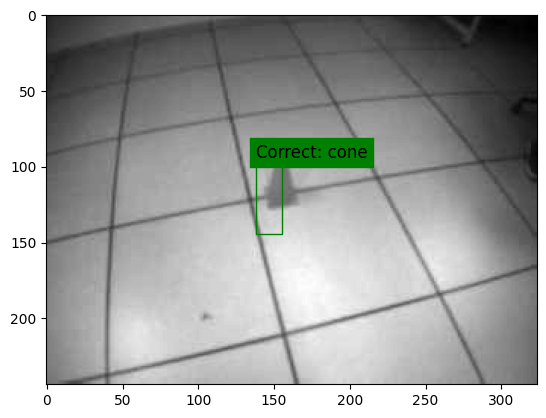

[0.51879895 0.39091352 0.6311111  0.52568644]
244 324
[168.  95. 204. 128.]


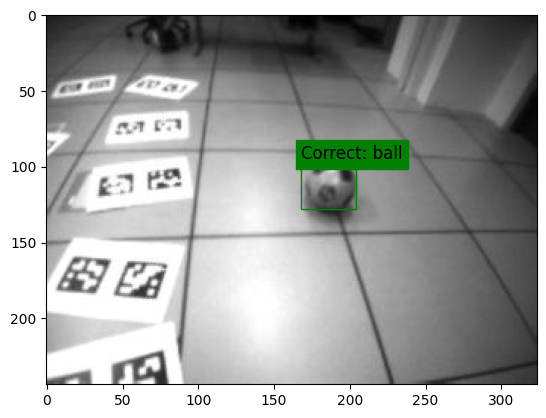

[0.44212705 0.17324439 0.5331797  0.39197117]
244 324
[143.  42. 172.  95.]


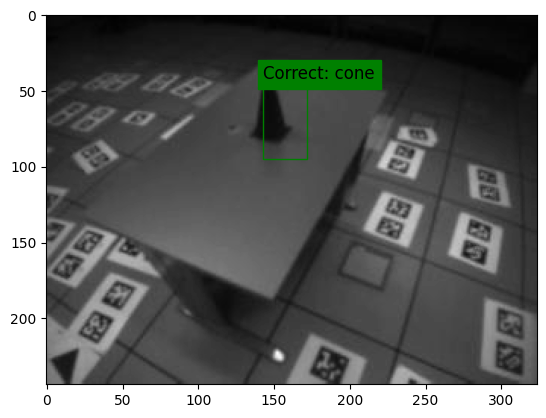

[0.3949436  0.2665722  0.58340245 0.47702783]
244 324
[127.  65. 189. 116.]


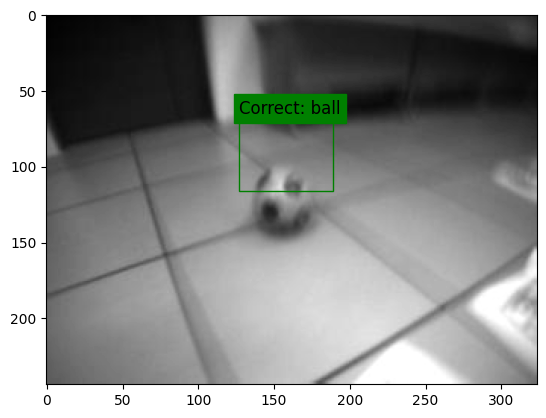

[0.4950406  0.23197778 0.5548899  0.42637616]
244 324
[160.  56. 179. 104.]


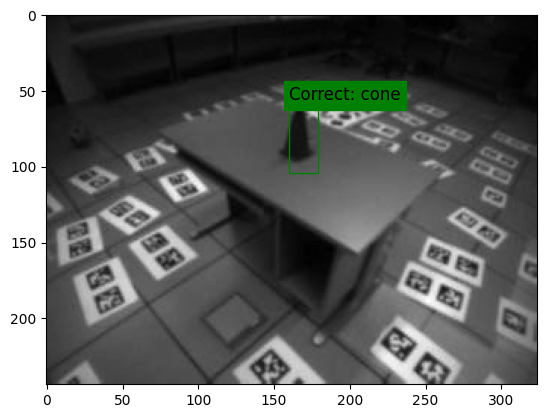

[0.8810808  0.20703971 0.6962984  0.3459316 ]
244 324
[285.  50. 225.  84.]


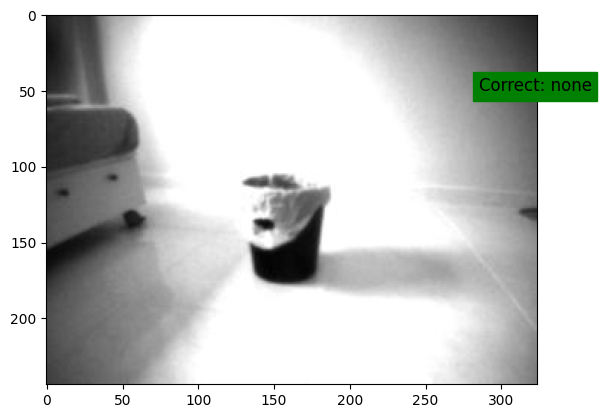

[ 0.7688498  -0.04591091  0.77259135  0.31719494]
244 324
[249. -11. 250.  77.]


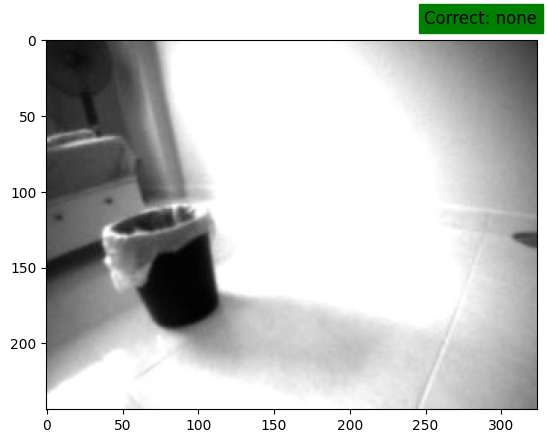

[0.39223206 0.2705473  0.53578126 0.471927  ]
244 324
[127.  66. 173. 115.]


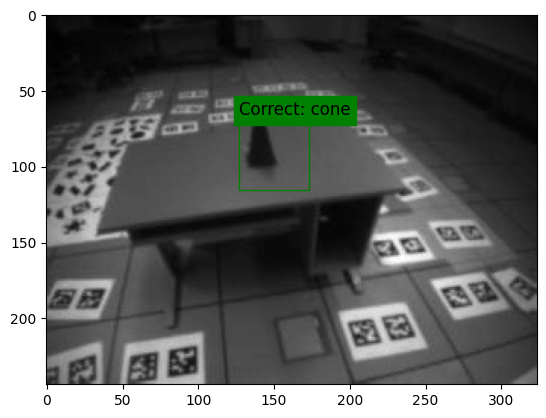

[0.40690237 0.34746373 0.47143203 0.4879324 ]
244 324
[131.  84. 152. 119.]


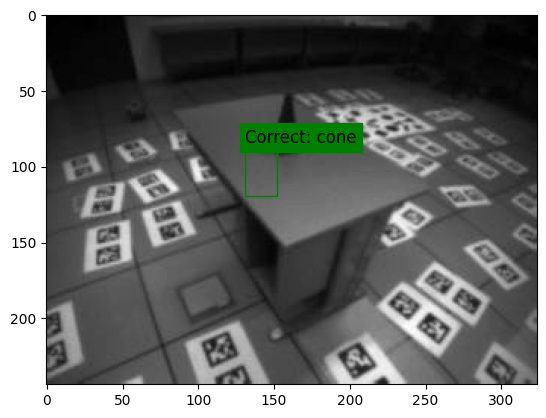

[0.485514  0.2968838 0.5520306 0.4617669]
244 324
[157.  72. 178. 112.]


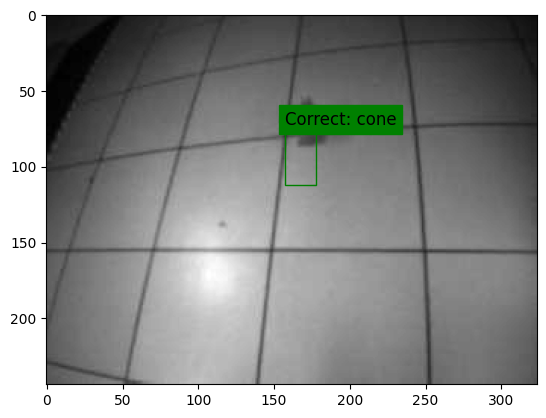

In [34]:
import matplotlib.pyplot as plt

# Loads the weights
# model = tf.keras.models.load_model('model/detector8_20.h5')

# Function to visualize bounding boxes and class labels on images
def visualize_predictions(image, bbox, pred_label, label):
    image = np.transpose(image, (1, 0))
    height, width = image.shape
    print(height, width)
    bbox[0] = int(bbox[0] * width)
    bbox[1] = int(bbox[1] * height)
    bbox[2] = int(bbox[2] * width)
    bbox[3] = int(bbox[3] * height)
    print(bbox)

    
    plt.figure()
    plt.imshow(image, cmap='gray')
    xmin, ymin, xmax, ymax = bbox

    if (pred_label == 1 and label == "ball") or (pred_label == 2 and label == "cone"):
        plt.text(xmin, ymin, f'Correct: {label}' , fontsize=12, backgroundcolor='g')
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                    edgecolor='g', facecolor='none'))
    elif (pred_label == 0 or label == "none"):
        plt.text(xmin, ymin, f'Correct: {label}' , fontsize=12, backgroundcolor='g')
    else:
        plt.text(xmin, ymin, f'Wrong: Not {label}' , fontsize=12, backgroundcolor='r')
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                    edgecolor='r', facecolor='none'))
    plt.axis('on')
    plt.show()

# Make predictions on test dataset
predictions = model.predict(test_images)

# Parse predictions
predicted_labels = predictions[0]
predicted_bboxes = predictions[1]

# Visualize predictions for a few images
num_images_to_visualize = 10
x = np.random.randint(0, 20)
for i in range(x, x+num_images_to_visualize):
    image = test_images[i]  # Get the image
    label = test_labels[i]  # True label
    pred_label = np.argmax(predicted_labels[i])  # Predicted label
    bbox = predicted_bboxes[i]  # Predicted bounding box
    print(bbox)

    # Visualize predictions
    visualize_predictions(image.squeeze(), bbox, pred_label, label)



## Export Model as TF Lite (NOT Quantised)

In [33]:
print('Exporting to TFLite')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(f"model/detection.tflite", "wb") as f:
    f.write(tflite_model)
print('Exported to TFLite')

Exporting to TFLite
INFO:tensorflow:Assets written to: /tmp/tmppo5ps93x/assets


INFO:tensorflow:Assets written to: /tmp/tmppo5ps93x/assets


Exported to TFLite


2024-02-19 20:26:01.265644: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-19 20:26:01.265671: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-19 20:26:01.266015: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmppo5ps93x
2024-02-19 20:26:01.288827: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-19 20:26:01.288859: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmppo5ps93x
2024-02-19 20:26:01.336001: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-02-19 20:26:01.364251: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-19 20:26:01.935884: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmppo5ps93x
2024-02

## Export Model as TFLite (QUANTISED 8 BIT)
- Go to netron.app to visualise model

In [35]:
print('Quantizing the model')
# Convert to quantized TensorFlow Lite
def representative_data_gen():
    for index, row in test_image_records.iterrows():
        (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

        test_image_fullpath = os.path.join(test_image_path, filename)
        test_img = keras.preprocessing.image.load_img(test_image_fullpath, target_size=(height, width), color_mode='grayscale')  # Convert to grayscale
        test_img_arr = keras.preprocessing.image.img_to_array(test_img)
        test_img_arr = np.transpose(test_img_arr, (1, 0, 2))
        print(test_img_arr.shape)
        test_img_arr = np.expand_dims(test_img_arr, axis=0)  # Add an extra dimension for batch
        yield [test_img_arr.astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open(
    f"model/detection_q.tflite", "wb"
) as f:
    f.write(tflite_model)

Quantizing the model
INFO:tensorflow:Assets written to: /tmp/tmpa2ybgzn7/assets


INFO:tensorflow:Assets written to: /tmp/tmpa2ybgzn7/assets
/home/cweekiat/anaconda3/envs/cf/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-02-19 20:26:46.899598: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-19 20:26:46.899647: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-19 20:26:46.899825: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpa2ybgzn7
2024-02-19 20:26:46.922496: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-19 20:26:46.922558: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpa2ybgzn7
2024-02-19 20:26:46.993016: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-19

(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 244, 1)
(324, 

fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


## Testing Quantised vs un-Quantised TFLite Model

(1, 324, 244, 1)
Quantised:
Output_classes:  0
Output_boxes:  [0.5339506  0.37295082 0.5308642  0.5       ]
244 324
[173.  91. 171. 122.]


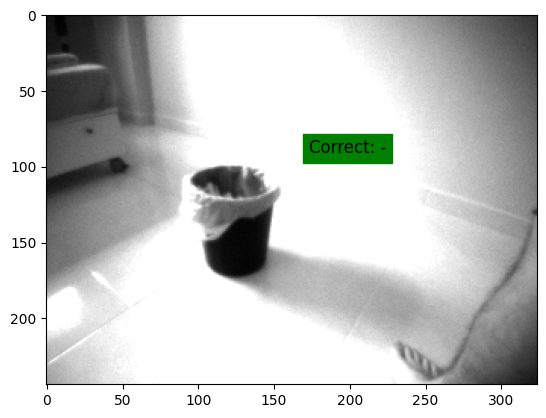

un-Quantised:
[9.9994743e-01 2.2452557e-06 5.0248818e-05]
Output_classes:  0
Output_boxes:  [0.65470296 0.09975139 0.5717142  0.2570895 ]
244 324
[212.  24. 185.  62.]


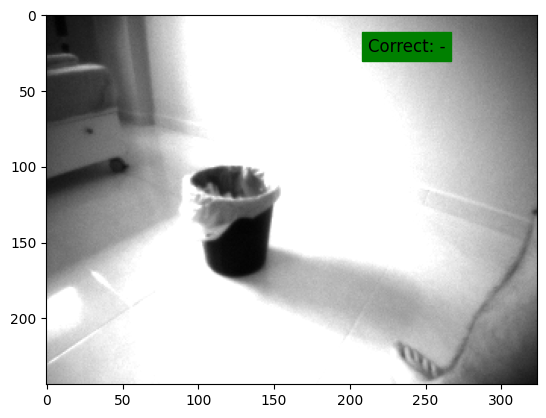

In [37]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
x = str(np.random.randint(10, 90))
image = 'samples/img_000032.png'
QUANTISED = 1

# if QUANTISED:
model_path = 'model/detection_q.tflite'
test_img = keras.preprocessing.image.load_img(image, target_size=(height, width), color_mode='grayscale')  
test_img_arr = np.array(keras.preprocessing.image.img_to_array(test_img))
test_img_arr = np.transpose(test_img_arr, (1, 0, 2))
input_image = np.expand_dims(test_img_arr.astype(np.uint8), axis=0)  

print(input_image.shape)

interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.set_tensor(input_details[0]['index'], input_image)
interpreter.invoke()

output_boxes = interpreter.get_tensor(output_details[1]['index'])
output_classes = interpreter.get_tensor(output_details[0]['index'])
pred_label = np.argmax(output_classes[0])
bbox = output_boxes[0].astype(np.float32)

bbox[0] /= width
bbox[1] /= height
bbox[2] /= width
bbox[3] /= height
# bbox = (output_boxes[0]-2)*0.003017221810296178 # Quantisation Values
print('Quantised:')
print('Output_classes: ', pred_label)
print('Output_boxes: ', bbox)
visualize_predictions(input_image.squeeze(), bbox, pred_label, "-")

model_path = 'model/detection.tflite'
test_img = keras.preprocessing.image.load_img(image, target_size=(height, width), color_mode='grayscale') 
test_img_arr = np.array(keras.preprocessing.image.img_to_array(test_img))
test_img_arr = np.transpose(test_img_arr, (1, 0, 2))
input_image = np.expand_dims(test_img_arr.astype(np.float32), axis=0) 
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.set_tensor(input_details[0]['index'], input_image)
interpreter.invoke()

output_boxes = interpreter.get_tensor(output_details[1]['index'])
output_classes = interpreter.get_tensor(output_details[0]['index'])
pred_label = np.argmax(output_classes[0])
bbox = output_boxes[0]
print('un-Quantised:')
print(output_classes[0])
print('Output_classes: ', pred_label)
print('Output_boxes: ', bbox)

visualize_predictions(input_image.squeeze(), bbox, pred_label, "-")
